# BS Optimization

- Solving a constrained resource allocation problem using a sample Bank balance sheet and (mostly) realistic balance sheet constraints

### Background

Bank resource management has become significantly more complex in the last decade. After the 2008 financial crisis, a slew of new regulatory frameworks were enacted, complicating balance sheet management. It was no longer immediately obvious which products were more profitable or what the optimal balance sheet mix was for a given "type" of bank (i.e., Universal vs. Investment vs. Retail bank, etc).

This is where optimization can help. These constraints can be expressed as equations, and by creating bounds on the Balance Sheet (abbreviated here on out as B/S) line items, these equations can be solved in a way that maximizes the profitability of the balance sheet.

### Balance Sheet Overview

Sample data can be found here: https://github.com/marvelje/bs_optimization/tree/main/data

- For purposes of this analysis, I've created a fake bank balance sheet of ~40 line items. I've relied on my experience at a big bank to construct a reasonably realistic scenario for a "universal" bank (i.e., a bank offering a full suite of banking services across retail, commercial, and markets). Many of these line items will look familiar to anyone who's worked in finance. You'll notice auto loans, various types of mortgage products, commercial lending, markets, and a whole suite of deposit products.
- For any optimization to have meaningful results, the line items should be broken down in a way where the bundled products have similar levels of profitability and "resource footprints" (more on this last bit under the Constraints Overview). The more aggregated the data, the less useful it becomes. Therefore, I've broken down a given product category where a subgroup has meaningfully different characteristics. For example, I broke Auto lending down between "Prime" and "Subprime" since the returns and resource footprint is materially different.
- I then created spreads (profitability expressed in basis points, or bps), along with upper and lower bounds. I.e., how much will I allow the products to grow and shrink during the optimization.
- To start, I generated somewhat arbitrary numbers, ensuring only that Assets = Liabilities and the constraints are currently satisfied

### Constraint overview

- This analysis presents a simplified version of the variety of constraints that a large bank currently faces
- Risk weighted assets:
    - This framework attemnpts to turn a given balance into a Risk Weight equivalent. For example, a mortgage loan may have a Standardized RWA of 50%. This means that a 100 dollar mortgage will generate Standardized RWA of 50.
    - The regulation states that the bank must have equity equal to a fixed % of it's Risk Weighted Assets. This is the crux of the give and take of the optimization. Equity is expensive! The bank would prefer not to hold more equity than it needs to so understanding the trade-offs here is important.
    - There are two RWA frameworks: Advanced and Standardized. A given product may have two different weights across each of these frameworks
- GSIB:
    - This is not a standalone constraint, but rather adds to the RWA minimums described above.
    - For example, the RWA minimum may be 8% plus a GSIB surchage, let's say 3%. The GSIB surcharge scales up or down with changes to the balance sheet, with some products contributing more to the GSIB surcharge than others.
    - In reality, this is a "stair-step" framework. The GSIB surcharge moves in increments of 0.5% A given score may place you in the 3% "bucket" until you hit the subsequent threshold, bumping you up to 3.5%. To keep this a linear problem, I removed this stair step and interpolated the GSIB contribution. In othe words, a small increase in balances may make the surcharge 3.05%, when in reality we would've stayed in the 3% bucket. This is the correct approach under a linear framework, although this could be reframed as a non-linear problem to account for this 
- Leverage:
    - This works similarly, but is a bit more straightforward. For example, the leverage requirement for CET1 states that you must have enough Equity to cover at least a fied % of the total assets. Functions similarly as RWA, but there's no intermediate step of 
    
The TLAC stack:
- Each RWA constraint has four components: CET1, T1, Total Capital, and TLAC. Collectively, these comprise the "resource stack". Different resource can contribute to meeting the minimum requirements for each of the levels. And they are additive. For example, the CET1 requirement might be 11% of RWA and this can only be met through equity. T1 minimum might be 13% but can be met with either Equity or Preferred Equity. Total Capital may be 15%, but subordinated debt can be used, etc. Equity is the most expense resource so that will not be used to meet requirements beyond CET1 if there are other options.
- For Leverage, there are only requirements at the CET1 and T1 level.
- Below is an illustration of the typical bank resource stack

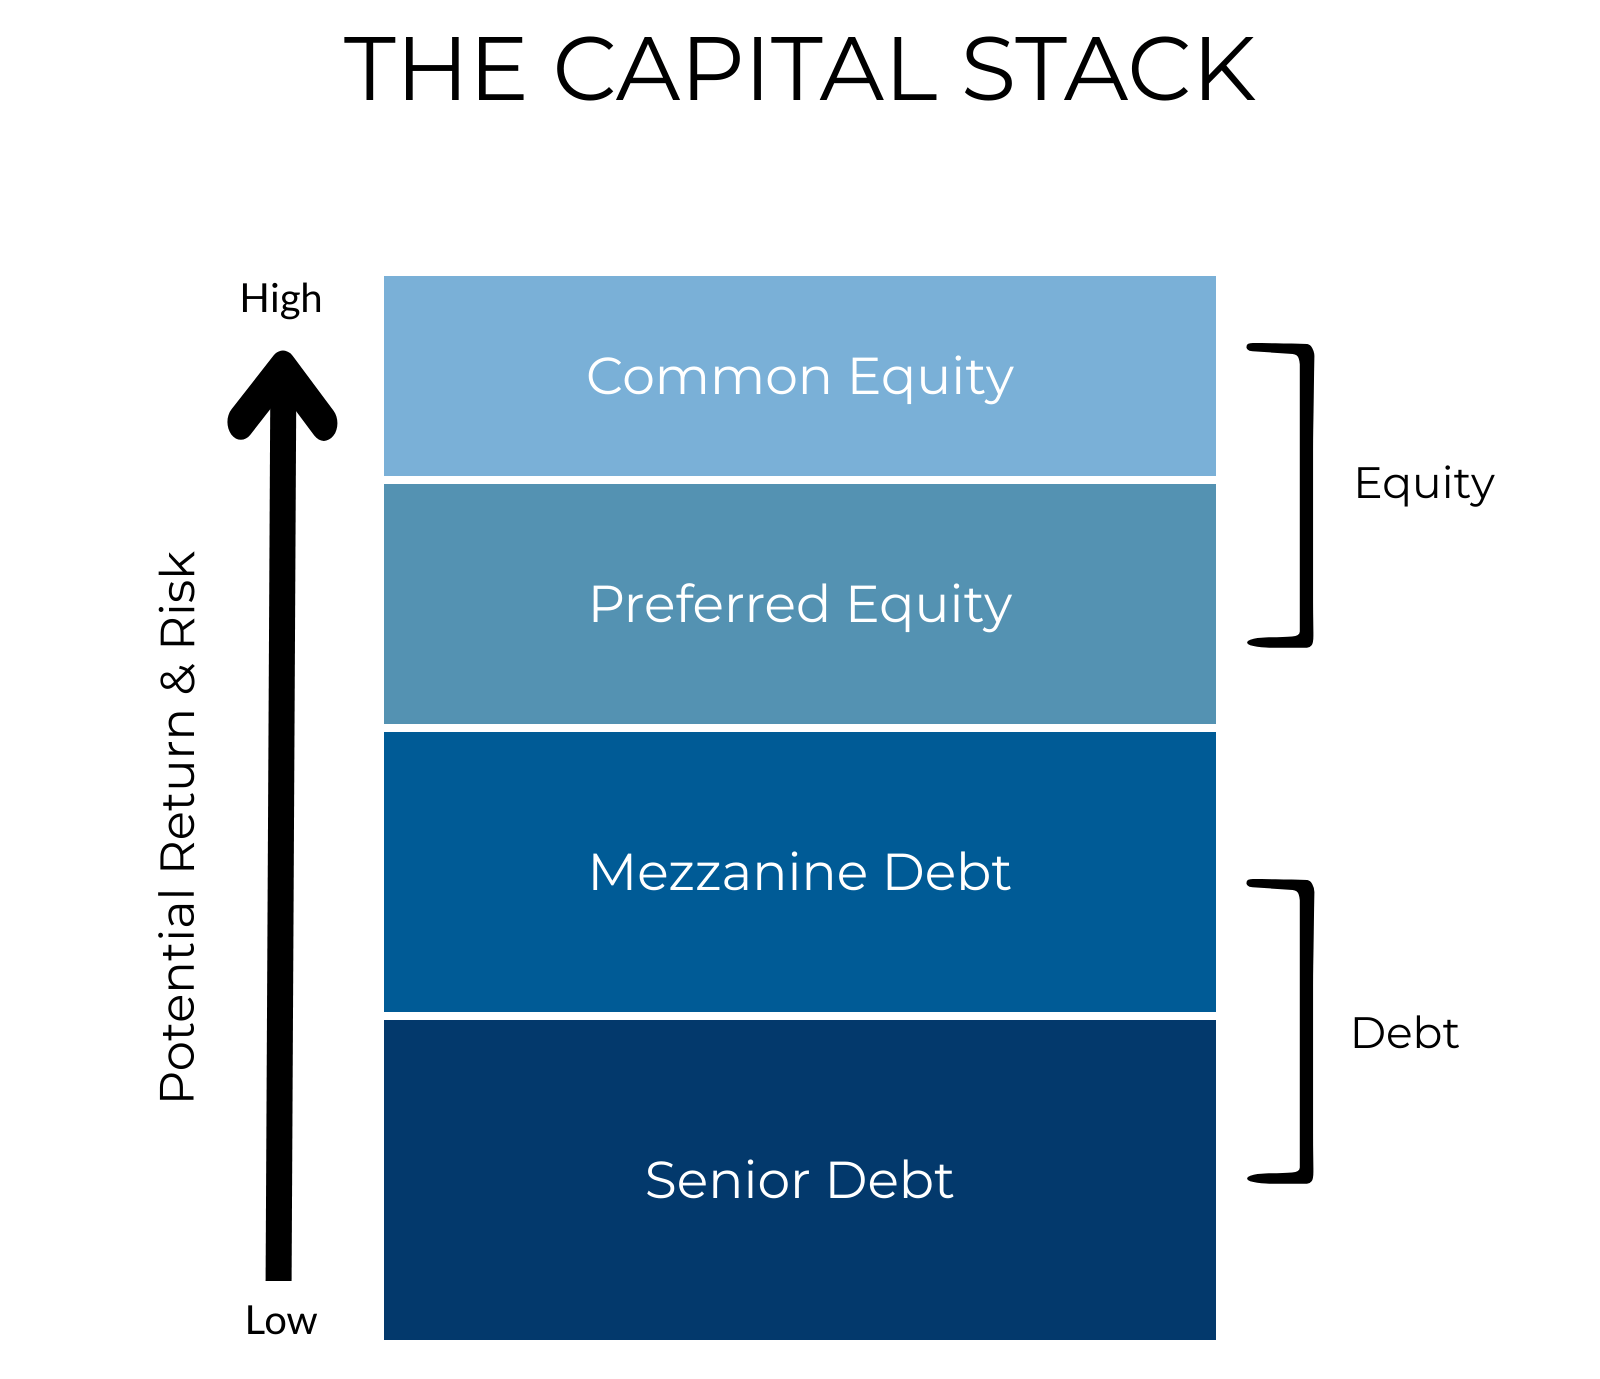

Source: https://www.crowdengine.com/cre-basics-the-capital-stack/

### Modeling

- My tool of choice is Scipy's linprog function, which minimizes an objective function subject to linear equality and inequality constraints. This was chosen over Sciopy's minimize function because it's better suited to handling multiple constraints like in this problem.
- All constraints for this problem are expressed as linear equations. This makes linprog a perfect tool for the job. However, some of the constraints may have a non-linear component, which would require a different tool / approach. Assumptions have been made to "linearize" these constraints
- The primary output will be the ending balances of all of our line items. This represents the "optimal" balance sheet and should be the one that's maximized profitability.

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt

In [2]:
# Set options to print all columns of the dataframe

pd.set_option('display.max_columns', None)

In [78]:
# Read in BS data

df = pd.read_excel('./data/sample_bs.xlsx', index_col=0, nrows=40, usecols='A:AO')

In [79]:
df.head()

,Product,start,grow,shrink,spread,A_L,b1_leverage,a_rwa,s_rwa,gsib_leverage,gsib_xjd_claim,gsib_xjd_liab,gsib_intrafin_claim,gsib_intrafin_liab,gsib_securities,gsib_payment,gsib_auc,gsib_underwriting,gsib_otc,gsib_trading,gsib_level3,CET1_resource,T1_resource,total_capital_resource,TLAC_resource,gsib_leverage_score,gsib_xjd_claim_score,gsib_xjd_liab_score,gsib_intrafin_claim_score,gsib_intrafin_liab_score,gsib_securities_score,gsib_payment_score,gsib_auc_score,gsib_underwriting_score,gsib_otc_score,gsib_trading_score,gsib_level3_score,total_score,cet1_contr
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,prime_auto,15000,8000,-5000,80,1,1,0.2,1.0,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,3.0,0.000144
2,subprime_auto,4000,2000,-1000,150,1,1,0.8,1.0,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.8,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0.8,0.000039
3,mtg_30_fixed,50000,30000,-15000,70,1,1,0.3,0.5,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,10.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,10.0,0.000482
4,mtg_15_fixed,15000,8000,-3000,72,1,1,0.3,0.5,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,3.0,0.000144
5,mtg_7_fixed,5000,2500,-2000,70,1,1,0.3,0.5,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,1.0,0.000048


In [80]:
df.tail()

,Product,start,grow,shrink,spread,A_L,b1_leverage,a_rwa,s_rwa,gsib_leverage,gsib_xjd_claim,gsib_xjd_liab,gsib_intrafin_claim,gsib_intrafin_liab,gsib_securities,gsib_payment,gsib_auc,gsib_underwriting,gsib_otc,gsib_trading,gsib_level3,CET1_resource,T1_resource,total_capital_resource,TLAC_resource,gsib_leverage_score,gsib_xjd_claim_score,gsib_xjd_liab_score,gsib_intrafin_claim_score,gsib_intrafin_liab_score,gsib_securities_score,gsib_payment_score,gsib_auc_score,gsib_underwriting_score,gsib_otc_score,gsib_trading_score,gsib_level3_score,total_score,cet1_contr
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36,synthetic_arwa_liability,0,0,0,5,-1,0,0.0,0.0,0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.000000
37,equity,54000,100000,-52500,-1000,-1,0,0.0,0.0,0,0.0,0,0.0,0,1,0,0,0,0.0,0.0,0.0,1,1,1,1,0.0,0.0,0.0,0.0,0.0,16.2,0,0.0,0,0.0,0,0.0,16.2,0.000780
38,prefs,8000,13000,-7000,-650,-1,0,0.0,0.0,0,0.0,0,0.0,0,1,0,0,0,0.0,0.0,0.0,0,1,1,1,0.0,0.0,0.0,0.0,0.0,2.4,0,0.0,0,0.0,0,0.0,2.4,0.000116
39,sub_debt,11000,20000,-9500,-200,-1,0,0.0,0.0,0,0.0,0,0.0,0,1,0,0,0,0.0,0.0,0.0,0,0,1,1,0.0,0.0,0.0,0.0,0.0,3.3,0,0.0,0,0.0,0,0.0,3.3,0.000159
40,senior_debt,43000,60000,-40000,-120,-1,0,0.0,0.0,0,0.0,0,0.0,0,1,0,0,0,0.0,0.0,0.0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,12.9,0,0.0,0,0.0,0,0.0,12.9,0.000621


In [5]:
# Read in constraints

constraints = pd.read_excel('./data/sample_bs.xlsx', index_col=0, sheet_name='constraints')

constraints

,CET1,T1,total_capital,TLAC
SRWA,0.080000,0.095,0.115,0.195
ARWA,0.080000,0.095,0.115,0.195
leverage,0.075000,0.090,NaN,NaN
GSIB,0.000048,NaN,NaN,NaN


In [28]:
# Read in GSIB coefficients

gsib = pd.read_excel('./data/sample_bs.xlsx', index_col=0, sheet_name='gsib')

## Objective function

- This is simply an array of the negative return (i.e., profitability)
- Since the optimization will actually be minimizing this, we just flip the sign 

In [6]:
# Define objective function coefficients
# We are 'minimizing' the spread so will make this negative
# Dividing by 10,000 to convert bps to spread (will not affect optimization)

c = -np.array(df['spread'] / 10000)

## Inequality Constraint

- The inequality contraints state that you must have enough resources (of the correct type) to cover a given % of the risk weighted assets on the B/S.
- Each B/S line item contributes some amount to RWA
- Taking CET1 as an example, there must be enough equity to cover 8% of RWA plus the GSIB surcharge
- This GSIB surcharge has beene "linearized" and each B/S line item adds (or subtracts) a certain amount from this minimum requirement as balances change
- The final formula for CET1 is as follows:
    - The inequality constraint for our optimization is the the RWA % * (8% base + GSIB surcharge) * the balance - equity needs to be greater than or equal to 0.
    - For other constraints in the resource stack, additional resources count towards fulfilling this requirement. For example, for T1 capital, this constraint can be met with both Equity and Prefs. However, the underlying principle is hte same.

### Advanced RWA

In [7]:
# Extract Advanced RWA inequality coefficients

aRWA_mins = list(constraints.loc['ARWA', :])

aRWA_cet1 = list(df['a_rwa'] * (aRWA_mins[0] + df['cet1_contr'].sum()) - df['CET1_resource'])
aRWA_t1 = list(df['a_rwa'] * (aRWA_mins[1] + df['cet1_contr'].sum()) - df['T1_resource'])
aRWA_tc = list(df['a_rwa'] * (aRWA_mins[2] + df['cet1_contr'].sum()) - df['total_capital_resource'])
aRWA_tlac = list(df['a_rwa'] * (aRWA_mins[3] + df['cet1_contr'].sum()) - df['TLAC_resource'])

# Combine into one list
aRWA_constraints = [aRWA_cet1, aRWA_t1, aRWA_tc, aRWA_tlac]

### Standardized RWA

In [67]:
# Extract RWA inequality coefficients

sRWA_mins = list(constraints.loc['SRWA', :])

sRWA_cet1 = list(df['s_rwa'] * (sRWA_mins[0] + df['cet1_contr'].sum()) - df['CET1_resource'])
sRWA_t1 = list(df['s_rwa'] * (sRWA_mins[1] + df['cet1_contr'].sum()) - df['T1_resource'])
sRWA_tc = list(df['s_rwa'] * (sRWA_mins[2] + df['cet1_contr'].sum()) - df['total_capital_resource'])
sRWA_tlac = list(df['s_rwa'] * (sRWA_mins[3] + df['cet1_contr'].sum()) - df['TLAC_resource'])

# Combine into one list

sRWA_constraints = [sRWA_cet1, sRWA_t1, sRWA_tc, sRWA_tlac]

In [70]:
list(df['s_rwa'] * (sRWA_mins[0] + df['cet1_contr'].sum()))

[0.11000000000000001,
 0.11000000000000001,
 0.05500000000000001,
 0.05500000000000001,
 0.05500000000000001,
 0.05500000000000001,
 0.05500000000000001,
 0.11000000000000001,
 0.11000000000000001,
 0.11550000000000002,
 0.11000000000000001,
 0.11770000000000003,
 0.11000000000000001,
 0.06050000000000001,
 0.04950000000000001,
 0.04950000000000001,
 0.06050000000000001,
 0.04400000000000001,
 0.005500000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [68]:
sRWA_cet1

[0.11000000000000001,
 0.11000000000000001,
 0.05500000000000001,
 0.05500000000000001,
 0.05500000000000001,
 0.05500000000000001,
 0.05500000000000001,
 0.11000000000000001,
 0.11000000000000001,
 0.11550000000000002,
 0.11000000000000001,
 0.11770000000000003,
 0.11000000000000001,
 0.06050000000000001,
 0.04950000000000001,
 0.04950000000000001,
 0.06050000000000001,
 0.04400000000000001,
 0.005500000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0]

### Leverage

- Leverage works very similarly to the RWA constraints with two exceptions:
    - There is no RWA intermediary. The Asset balances are directly multiplied by the CET1 (or T1) minimums.
    - GSIB is not a factor

In [9]:
# Extract leverage inequality constraint

lev_mins = list(constraints.loc['leverage',['CET1', 'T1']])

lev_cet1 = list(df['b1_leverage'] * lev_mins[0] - df['CET1_resource'])
lev_t1 = list(df['b1_leverage'] * lev_mins[1] - df['T1_resource'])

# Combine into one list

lev_constraints = [lev_cet1, lev_t1]

In [10]:
# Combine Advanced RWA and Standardized RWA constraints into a single list

A_ineq = aRWA_constraints + sRWA_constraints + lev_constraints

# Define the other side of the inequality equation (we want to be at least at the minimum, so this is 0)
# There are 10 constraints so this gets multiplied accordingly

b_ineq = [0] * 10

In [11]:
A_ineq

[[0.022000000000000006,
  0.08800000000000002,
  0.033,
  0.033,
  0.033,
  0.033,
  0.033,
  0.132,
  0.10450000000000001,
  0.08250000000000002,
  0.077,
  0.08250000000000002,
  0.07150000000000001,
  0.04400000000000001,
  0.05500000000000001,
  0.04400000000000001,
  0.05500000000000001,
  0.022000000000000006,
  0.005500000000000001,
  0.11000000000000001,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -1.0,
  0.0,
  0.0,
  0.0],
 [0.025,
  0.1,
  0.0375,
  0.0375,
  0.0375,
  0.0375,
  0.0375,
  0.15,
  0.11875,
  0.09375,
  0.0875,
  0.09375,
  0.08125,
  0.05,
  0.0625,
  0.05,
  0.0625,
  0.025,
  0.00625,
  0.125,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -1.0,
  -1.0,
  0.0,
  0.0],
 [0.029000000000000005,
  0.11600000000000002,
  0.043500000000000004,
  0.043500000000000004,
  0.043500000000000004,
  0.043500000000000004,
  0.0435000000

## Equality Constraint

- This constraint states that Assets - Liabilities must equal to 0. This makes sense as our balance sheet always needs to balance
- I've pre-programmed this to an extent by including a assets (+100%) and liability (-100%) weight in the inputs.

In [12]:
# Create Asset and Liability equality constraint.

A_eq = [list(df['A_L'])]

In [13]:
# Equality constraint vector defined below. This is saying that assets must equal liabilities on the B/S

a_l_constraint = 0

b_eq = [a_l_constraint]

In [14]:
# Create upper and lower bounds. This is the grow and shrink amount for each item

df['u_bound'] = df['start'] + df['grow']
df['l_bound'] = df['start'] + df['shrink']

# Create tuple of lower / upper bounds to make sure it's in the appropriate format for Scipy's linprog
df['bounds'] = df.apply(lambda row: tuple((row['l_bound'], row['u_bound'])), axis=1)

In [15]:
# Define bounds in format needed for linprog

bounds = list(df['bounds'])

## Optimize B/S

In [73]:
try 

NameError: name 'x0' is not defined

In [16]:
res = spo.linprog(c, A_ub = A_ineq, b_ub = b_ineq, A_eq = A_eq, b_eq = b_eq, bounds = bounds, 
                  method='revised simplex', options = {"disp": True})

Phase Iteration Minimum Slack       Constraint Residual Objective          
1     0         -82685.5625         148450.0            -13813.8            
1     1         -49785.5375         115549.975          -10523.7975         
1     2         -46094.625          111859.0625         -10154.70625        
1     3         -43276.8125         109041.25           -9872.925           
1     4         -41340.075          107104.5125         -9679.25125         
1     5         -40339.2875         106103.725          -9579.1725          
1     6         -36095.0625         101859.5            -9303.297875        
1     7         -35360.25           101124.6875         -9255.5350625       
1     8         -28888.2            94652.6375          -9126.0940625       
1     9         -19321.875          85086.3125          -9011.2981625       
1     10        -3.637978807092e-12 65764.4375          -8779.4356625       
1     11        -3.637978807092e-12 0.0                 -10094.7244125      


## Results

In [17]:
# This shows that a solution was found

res.success

True

In [18]:
# Show the output of the objective function

res.fun

-14875.68194354839

In [19]:
# Compare to starting profitability

start_profitability = -sum(df['start'] * (df['spread'] / 10000))

(res.fun - start_profitability) / start_profitability

# Profitability increased 41%

0.41058549117401705

In [20]:
# Show the slack against each of the constraints.
# As expect, Standardized RWA (last four values) is significantly more binding than Advanced
# Leverage is binding at the T1 level

res.slack

array([12534.17887097, 16004.26733871, 16522.32669355, 25638.09314516,
           0.        ,  1760.88225806,     0.        ,     0.        ,
        1817.59274194,     0.        ])

In [21]:
# Show ending balances

res.x

array([ 10000.        ,   6000.        ,  80000.        ,  23000.        ,
         7500.        ,  30000.        ,  13500.        ,  80000.        ,
        17500.        ,  35000.        ,  62706.93548387,  28000.        ,
        85000.        , 105000.        ,  75000.        ,  95000.        ,
        34000.        ,  13000.        ,   1500.        ,      0.        ,
       240000.        ,  88500.        , 110000.        ,  26000.        ,
        30000.        ,   3500.        ,  75000.        ,  32000.        ,
        22000.        ,  12500.        ,  16000.        ,   9500.        ,
         5000.        ,   2000.        ,   3000.        ,      0.        ,
        61945.61290323,  10208.01129032,   9501.95645161,  45051.35483871])

In [22]:
df.head()

,Product,start,grow,shrink,spread,A_L,b1_leverage,a_rwa,s_rwa,gsib_leverage,gsib_xjd_claim,gsib_xjd_liab,gsib_intrafin_claim,gsib_intrafin_liab,gsib_securities,gsib_payment,gsib_auc,gsib_underwriting,gsib_otc,gsib_trading,gsib_level3,CET1_resource,T1_resource,total_capital_resource,TLAC_resource,gsib_leverage_score,gsib_xjd_claim_score,gsib_xjd_liab_score,gsib_intrafin_claim_score,gsib_intrafin_liab_score,gsib_securities_score,gsib_payment_score,gsib_auc_score,gsib_underwriting_score,gsib_otc_score,gsib_trading_score,gsib_level3_score,total_score,cet1_contr,u_bound,l_bound,bounds
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,prime_auto,15000,8000,-5000,80,1,1,0.2,1.0,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,3.0,0.000144,23000,10000,"(10000, 23000)"
2,subprime_auto,4000,2000,-1000,150,1,1,0.8,1.0,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.8,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0.8,0.000039,6000,3000,"(3000, 6000)"
3,mtg_30_fixed,50000,30000,-15000,70,1,1,0.3,0.5,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,10.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,10.0,0.000482,80000,35000,"(35000, 80000)"
4,mtg_15_fixed,15000,8000,-3000,72,1,1,0.3,0.5,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,3.0,0.000144,23000,12000,"(12000, 23000)"
5,mtg_7_fixed,5000,2500,-2000,70,1,1,0.3,0.5,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,1.0,0.000048,7500,3000,"(3000, 7500)"


In [23]:
# Append ending balance to our data and compare growth vs. shrink

balance_results = df.copy()
balance_results['optimal_balance'] = res.x

balance_results['balance_change'] = balance_results['optimal_balance'] - balance_results['start']

In [24]:
balance_results = balance_results[['Product', 'start', 'balance_change', 'optimal_balance', 'spread', 
                                   'total_score', 'cet1_contr', 'a_rwa', 's_rwa']]

In [25]:
# Some products are growing, some are shrinking, and business non-op deposits are our marginal product

balance_results

,Product,start,balance_change,optimal_balance,spread,total_score,cet1_contr,a_rwa,s_rwa
Index,,,,,,,,,
1,prime_auto,15000,-5000.000000,10000.000000,80,3.000,0.000144,0.20,1.00
2,subprime_auto,4000,2000.000000,6000.000000,150,0.800,0.000039,0.80,1.00
3,mtg_30_fixed,50000,30000.000000,80000.000000,70,10.000,0.000482,0.30,0.50
4,mtg_15_fixed,15000,8000.000000,23000.000000,72,3.000,0.000144,0.30,0.50
5,mtg_7_fixed,5000,2500.000000,7500.000000,70,1.000,0.000048,0.30,0.50
6,mtg_15_arm,20000,10000.000000,30000.000000,71,4.000,0.000193,0.30,0.50
7,mtg_7_arm,10000,3500.000000,13500.000000,75,2.000,0.000096,0.30,0.50
8,consumer_card,60000,20000.000000,80000.000000,550,12.000,0.000578,1.20,1.00
9,business_card,15000,2500.000000,17500.000000,400,3.000,0.000144,0.95,1.00


In [26]:
# Export updated results to Excel

balance_results.to_excel('./results/results.xlsx')

## Visualizations

- 

#### Appendix

- Saving down some code from a previous iteration that's currently not used

In [56]:
df.head()

,Product,start,grow,shrink,spread,A_L,b1_leverage,a_rwa,s_rwa,gsib_leverage,gsib_xjd_claim,gsib_xjd_liab,gsib_intrafin_claim,gsib_intrafin_liab,gsib_securities,gsib_payment,gsib_auc,gsib_underwriting,gsib_otc,gsib_trading,gsib_level3,CET1_resource,T1_resource,total_capital_resource,TLAC_resource,gsib_leverage_score,gsib_xjd_claim_score,gsib_xjd_liab_score,gsib_intrafin_claim_score,gsib_intrafin_liab_score,gsib_securities_score,gsib_payment_score,gsib_auc_score,gsib_underwriting_score,gsib_otc_score,gsib_trading_score,gsib_level3_score,total_score,cet1_contr,u_bound,l_bound,bounds
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,prime_auto,15000,8000,-5000,80,1,1,0.2,1.0,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,3.0,0.000144,23000,10000,"(10000, 23000)"
2,subprime_auto,4000,2000,-1000,150,1,1,0.8,1.0,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.8,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0.8,0.000039,6000,3000,"(3000, 6000)"
3,mtg_30_fixed,50000,30000,-15000,70,1,1,0.3,0.5,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,10.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,10.0,0.000482,80000,35000,"(35000, 80000)"
4,mtg_15_fixed,15000,8000,-3000,72,1,1,0.3,0.5,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,3.0,0.000144,23000,12000,"(12000, 23000)"
5,mtg_7_fixed,5000,2500,-2000,70,1,1,0.3,0.5,1,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,1.0,0.000048,7500,3000,"(3000, 7500)"


In [82]:
gsib_cols

['gsib_leverage',
 'gsib_xjd_claim',
 'gsib_xjd_liab',
 'gsib_intrafin_claim',
 'gsib_intrafin_liab',
 'gsib_securities',
 'gsib_payment',
 'gsib_auc',
 'gsib_underwriting',
 'gsib_otc',
 'gsib_trading']

In [83]:
# The below calculates the contribution of the GSIB score surcharge by line item

# Identify the GSIB-related columns
gsib_cols = list(df.columns[9:21])

# Multiply GSIB coefficients by starting balances and store in a new dataframe
gsib_impact = df[gsib_cols].multiply(df['start'], axis='index')
gsib_impact.set_index(df['Product'], inplace=True)

score_cols = []

# Multiply the gsib balances by their respective scores
for i, item in enumerate(gsib.index):
    col_name = item + '_score'
    score_cols.append(col_name)
    gsib_impact[col_name] = gsib_impact.iloc[:,i] * float(gsib.iloc[i])

# Sum across to calculate the "total GSIB score"
gsib_impact['total_score'] = gsib_impact[score_cols].sum(axis=1)

# Convert the score to the CET1 contribution, currently calibrated to be +3%
gsib_impact['cet1_cont'] = gsib_impact['total_score'] * constraints.loc['GSIB', 'CET1']

In [84]:
gsib_impact

,gsib_leverage,gsib_xjd_claim,gsib_xjd_liab,gsib_intrafin_claim,gsib_intrafin_liab,gsib_securities,gsib_payment,gsib_auc,gsib_underwriting,gsib_otc,gsib_trading,gsib_level3,gsib_leverage_score,gsib_xjd_claim_score,gsib_xjd_liab_score,gsib_intrafin_claim_score,gsib_intrafin_liab_score,gsib_securities_score,gsib_payment_score,gsib_auc_score,gsib_underwriting_score,gsib_otc_score,gsib_trading_score,gsib_level3_score,total_score,cet1_cont
Product,,,,,,,,,,,,,,,,,,,,,,,,,,
prime_auto,15000,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,3.0,0.000,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000,0.000144
subprime_auto,4000,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.8,0.000,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800,0.000039
mtg_30_fixed,50000,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,10.0,0.000,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.000,0.000482
mtg_15_fixed,15000,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,3.0,0.000,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000,0.000144
mtg_7_fixed,5000,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.000,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000048
mtg_15_arm,20000,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,4.0,0.000,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000,0.000193
mtg_7_arm,10000,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.000,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000,0.000096
consumer_card,60000,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,12.0,0.000,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.000,0.000578
business_card,15000,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,3.0,0.000,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000,0.000144


In [87]:
gsib_impact['cet1_cont'].sum()

0.030000000000000006